In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [2]:
using Revise

In [3]:
using Plots

In [4]:
import LineWorlds
const L = LineWorlds

LineWorlds

In [5]:
import GenPOMDPs
using Gen

In [6]:
_segs, _boxes, _bb, _center, _xs, _hds, _ps, _dxs, _dhds, _us, _T = L.load_env();

In [8]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; σ = 0.2),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.2,
            outlier      = 0.1,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [9]:
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

In [10]:
pos0 = uniform_agent_pos(PARAMS)

2-element Vector{Float64}:
  3.4880474815570457
 16.468857045611717

In [11]:
# The next position, under a 0-noise model, with no walls.
function det_next_pos((x, y), a)
    a == :up    ? [x, y + 1] :
    a == :down  ? [x, y - 1] : 
    a == :left  ? [x - 1, y] :
    a == :right ? [x + 1, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

# Given the old pos and a new pose the agent would move to
# in absense of walls -- find where the agent did move to,
# given that it can't pass through walls.
# Specificallly -- if the agent would have to pass
# through a wall to do this, don't move it.
# [TODO: have the agent move to the intersection point
# if it tries to go through a wall.]
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(prev, new)
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end

@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action)
    noisy_next_pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, noisy_next_pos, PARAMS.map)
    
    return next_pos
end
@load_generated_functions()

In [12]:
tr = simulate(motion_model, (pos0, :left, PARAMS));
get_choices(tr)

│
└── :noisy_next_pos : [2.4321261329856454, 16.350923074721507]


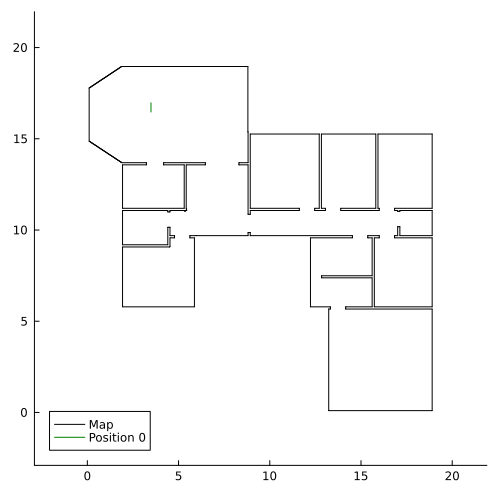

In [13]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos0, PARAMS.orientation), c=:green, label="Position 0")

In [21]:
### Observation Model ###

gm             = HomogeneousMixture(L.diagnormal, [1, 1])
outlier_dist   = L.diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = L.ProductDistribution(sensor_mix)

@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    # segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], params.map; num_a=params.obs.n_rays, zmax)
    # zs = reshape(dists, (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]
    
    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  
    
    return obs
end;
@load_generated_functions

In [23]:
obspts = sensor_model(pos0, PARAMS);

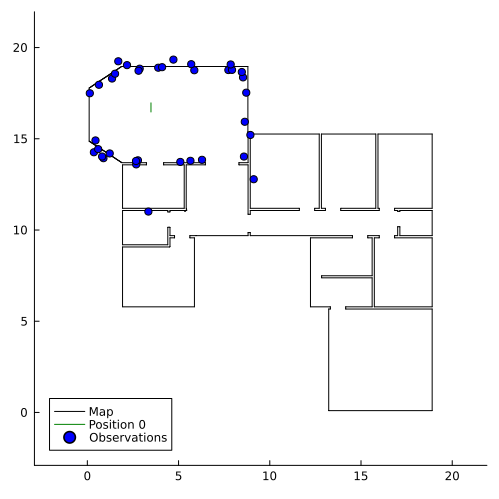

In [24]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos0, PARAMS.orientation), c=:green, label="Position 0")
scatter!(obspts.*L.Pose(pos0, PARAMS.orientation), c=:blue, label="Observations")

In [25]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(var"##StaticGenFunction_uniform_agent_pos#306"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_motion_model#329"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#400", Bool[0, 0], false), var"#60#61"())

In [26]:
# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#700"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [27]:
@load_generated_functions()

In [28]:
a = (x=1, b=2)
c = (a..., x=3)

(x = 3, b = 2)

In [29]:
PARAMS2 = (PARAMS..., obs=(
                PARAMS.obs...,
                sensor_args = (;
                    w            = 5,
                    s_noise      = 0.01,
                    outlier      = 0.000001,
                    outlier_vol = 100.0,
                    zmax = 100.0
                ),
                n_rays=360
            )
        );
tr = generate(trajectory_model, (
        15,
        [
            :down, :down,
            :right, :right,
            :down, :down, :down, :down,
            :down, :right, :right, :right, :right,
            :down, :down, :right, :right
        ],
        PARAMS,
    ), choicemap((GenPOMDPs.state_addr(0, :pos), [5., 17.]))
)[1];

In [30]:
poses = [
    L.Pose(position, PARAMS.orientation)
    for position in GenPOMDPs.state_sequence(tr)
];
ptclouds = [
    obss[:obs].*pose
    for (obss, pose) in zip(
        GenPOMDPs.observation_sequence(tr),
        poses
    )
];

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
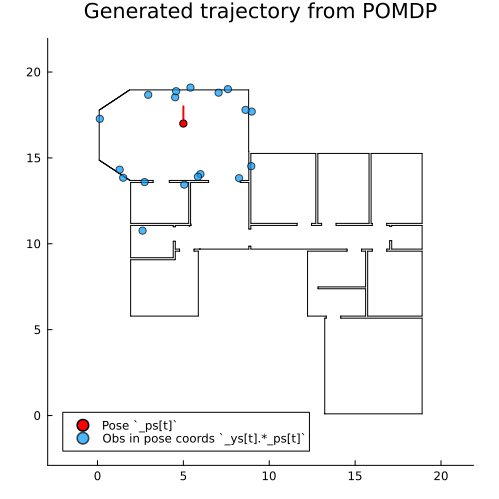

In [219]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)
    p = poses[t]
    y = ptclouds[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/loc_data_gen.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/loc_data_gen.gif")
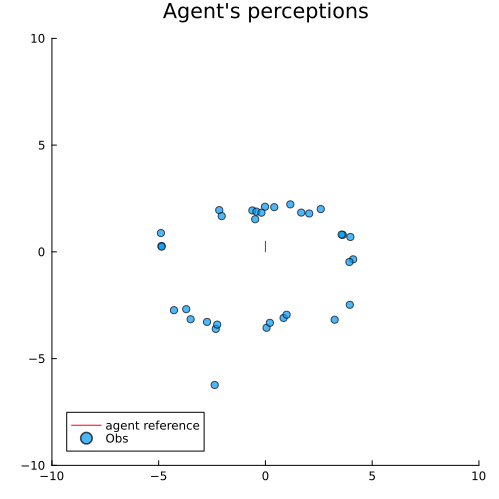

In [251]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)
    p = poses[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Agent's perceptions", grid=false,
        xlim=(-10, 10),
        ylim=(-10, 10),
        legend=:bottomleft,
    )
    plot!(L.Pose([0, 0], π/2), c=:red, label="agent reference")
    scatter!(Random.shuffle(
            GenPOMDPs.observation_sequence(tr)[t][:obs][1:1:end] .* L.Pose([0, 0], π/2)
        ), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs")

    frame(ani, agent_plt)
end
gif(ani, "loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
# gif(ani, fps=3)

In [240]:
pos_addr(t) = t == 0 ? GenPOMDPs.state_addr(0, :pos) : GenPOMDPs.state_addr(t, :noisy_next_pos)
@gen function pose_drift_proposal(tr, x_noise)
    T, = get_args(tr)
    pos  = tr[GenPOMDPs.state_addr(T)]

    {pos_addr(T)} ~ L.diagnormal(pos, [x_noise, x_noise])
    
    tr
end;

In [241]:
import GenParticleFilters
(pf_init, pf_step) = GenPOMDPs.pf(
    pomdp, PARAMS,
    (100,), # particles
    (); # bootstrap update
    pre_update = (state -> begin
        GenPOMDPs.systematic_resample_if_ess_below_onefifth_particlecount(state)
        GenParticleFilters.pf_rejuvenate!(
            state, Gen.mh, (pose_drift_proposal, (0.1,)), 5)
        end
    )
);

In [242]:
states = []
state = pf_init(GenPOMDPs.observation_sequence(tr)[1]);
push!(states, state)
for (a, obs) in zip(
        GenPOMDPs.action_sequence(tr)[2:end],
        GenPOMDPs.observation_sequence(tr)[2:end]
    )
    state = pf_step(state, a, obs)
    push!(states, state)
end
;

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
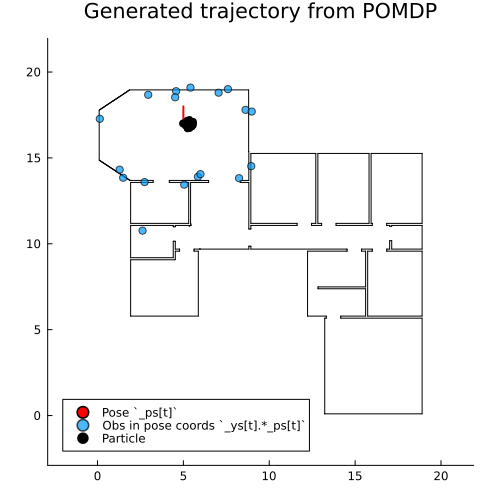

In [249]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=0:1:length(poses)-2
    p = poses[t + 1]
    y = ptclouds[t + 1]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    particles = states[t + 2]
    labeled=false
    for (w, tr) in zip(
            GenParticleFilters.get_norm_weights(particles),
            GenParticleFilters.get_traces(particles)
        )
        pos = tr[GenPOMDPs.state_addr(t)]
        if !labeled
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label="Particle")
            labeled=true
        else
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label=nothing)
        end
    end
    
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
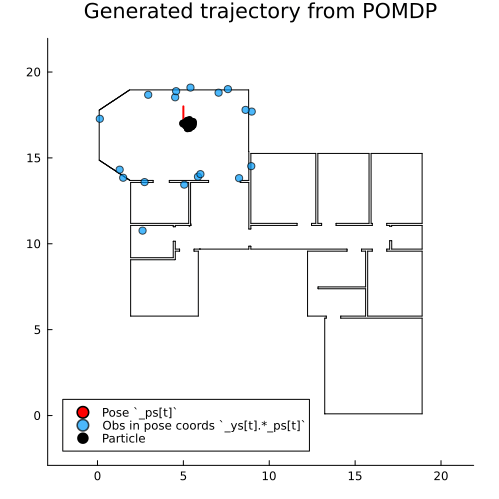

In [248]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=0:1:0
    p = poses[t + 1]
    y = ptclouds[t + 1]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    particles = states[t + 2]
    labeled=false
    for (w, tr) in zip(
            GenParticleFilters.get_norm_weights(particles),
            GenParticleFilters.get_traces(particles)
        )
        pos = tr[GenPOMDPs.state_addr(t)]
        if !labeled
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label="Particle")
            labeled=true
        else
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label=nothing)
        end
    end
    
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

In [227]:
GenParticleFilters.get_norm_weights(states[1])

100-element Vector{Float64}:
 3.1886224342565727e-55
 9.456339201037763e-46
 1.9630206746481578e-44
 7.847504965087234e-43
 9.494178085105285e-37
 4.886916342996123e-50
 9.100512680417489e-58
 2.5379893608349216e-21
 6.172812810462378e-55
 1.0
 2.8024350316818936e-51
 6.428888918731299e-49
 3.1799151600154457e-47
 ⋮
 1.0648291571012231e-44
 9.075146585091715e-58
 1.2599417292089792e-49
 9.075146587180442e-58
 9.075146585091715e-58
 1.3061684647939806e-57
 3.690270270411436e-55
 2.325974667516101e-33
 2.4029921410060247e-40
 6.105528239572189e-53
 5.96419689003766e-48
 1.0625910981843406e-51

In [228]:
get_submap(get_choices(tr_), GenPOMDPs.obs_addr(0))

│
└── :obs : [[-3.182098146151025, -0.5606932784534757], [-7.432987017671183, -3.8848389896075077], [-2.5486132182452277, -3.3422915442814034], [Inf, Inf], [-5.1188947836791545, -3.816544143822254], [-3.24762815185344, -0.25013892635023904], [-0.44334019142734854, -4.093556098971365], [-1.2024801118001582, -3.4463016933385804], [-7.361732766706908, -3.922909147083936], [-2.690851390551076, -3.8872728730253496], [1.7982041502188746, -3.709973024098262], [-2.3266364956590895, -3.869182708788424], [2.157058239124738, -1.1535361059752152], [1.549261162329806, -1.164357008865165], [Inf, Inf], [1.7238822161198277, -0.16068259855525935], [2.1168034129146958, -0.828558642650831], [1.7573056447817157, -3.669782132879707], [1.9535908946054517, -1.0022505202510177], [1.811209390616762, -0.11306890448720813], [1.9277467269070498, -0.03495635274034278], [2.307126617122129, 0.3823345317241621], [1.7772874138721448, -0.13556540137555], [1.9620772458132743, 1.5684703175723924], [1.5530280372359004, 2.

In [229]:
tr_ = GenParticleFilters.get_traces(states[1])[1]
pos = tr_[GenPOMDPs.state_addr(0)]
obspts = get_submap(get_choices(tr_), GenPOMDPs.obs_addr(0))[:obs]
assess(
    sensor_model,
    (pos, PARAMS),
    get_submap(get_choices(tr_), GenPOMDPs.obs_addr(0))
)

(-250.1324802754461, [[100.02787372965149, 0.26153512868095724], [99.91274829964442, 0.04237503342879103], [-2.4797676614205293, -3.9530578114949777], [-3.323953020231622, -0.20942705791759095], [-3.095657563719173, -0.8504834733510198], [-0.47315780533616214, -3.9344289628340303], [-2.944995716384743, -0.9925121189651855], [0.809925324954321, -3.5695127676227365], [-3.1800138573292234, -3.24313890262692], [-0.35010965137558553, -4.107363888680553]  …  [-3.155482262050822, 3.5036414546748094], [-2.732150914059326, 4.2835650520028], [-3.408214549351207, 2.2586955160739492], [-3.2817347742361576, 2.7359244722530485], [-3.5568471304884146, -0.052674065659771986], [-3.6097638993814365, 2.326028896478287], [-6.234748039828869, 2.376033037339236], [Inf, Inf], [-2.684702676880278, 3.70907881644752], [99.82243435249616, 0.14773236445311444]])

NaN

NaN

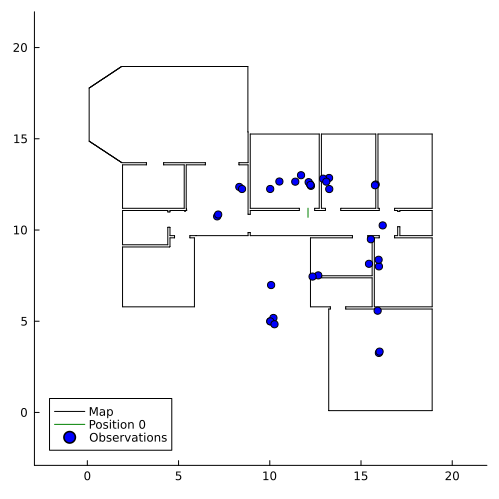

In [135]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos, PARAMS.orientation), c=:green, label="Position 0")
scatter!(obspts.*L.Pose(pos, PARAMS.orientation), c=:blue, label="Observations")

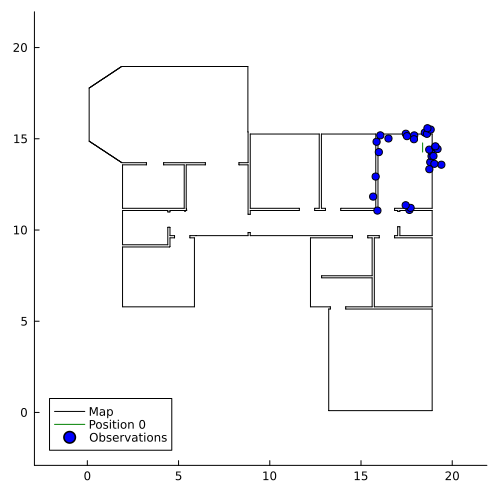

In [253]:
mypl